<a href="https://colab.research.google.com/github/MahdiZakipour/ML-MSc-Thesis/blob/main/%231_General-Project_CAT_and_DOG_Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)


The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this image below: 
(You will notice that the test directory has no subdirectories and the images are not labeled)
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```


In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

### Creating Image generators

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


In [ ]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)


train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                           batch_size = batch_size,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'binary')

val_data_gen = validation_image_generator.flow_from_directory(directory = validation_dir,
                                                              batch_size = batch_size,
                                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode = 'binary')

test_data_gen = test_image_generator.flow_from_directory(directory = PATH,
                                                         batch_size = batch_size,
                                                         target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         shuffle=False,
                                                         classes = ['test'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


### The `plotImages` function 
It takes an array of images and a probabilities list, although the probabilities list is optional. (The code is just used) 

Running the cell below will plot five random training images.

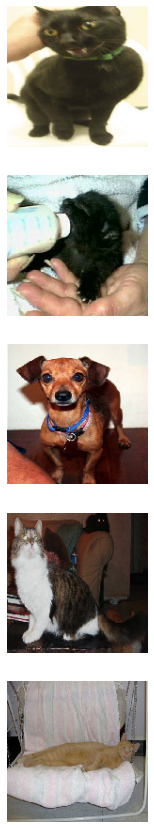

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


## Create More Training data (to avoid overfitting)
Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using ***Random Transformations*** (i.e. some Arguments in ImageDataGenerator, **for flipping & rotating & ...**).

Found 2000 images belonging to 2 classes.


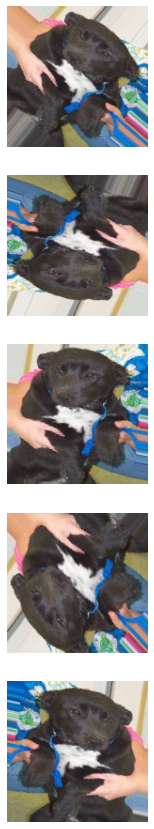

In [ ]:
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split = 0.2)


# Now, see the result of that:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [ ]:
# model creation
model = Sequential()
model.add(Conv2D(32, (3,3), 
                 input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
                 activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3,3),
                 activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3,3),
                 activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3,3),
                 activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))

# compliling
model.compile(metrics = ['accuracy'], 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam')

# get the summary of the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
# fit the data to the model
history = model.fit(x=train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=total_train // batch_size,
                    validation_data=val_data_gen
                    #, validation_steps=total_val // batch_size
                    )

Epoch 1/15
15/15 [==============================] - 113s 7s/step - loss: 0.7802 - accuracy: 0.4882 - val_loss: 0.6917 - val_accuracy: 0.6310
Epoch 2/15
15/15 [==============================] - 111s 7s/step - loss: 0.6914 - accuracy: 0.5475 - val_loss: 0.6868 - val_accuracy: 0.5830
Epoch 3/15
15/15 [==============================] - 112s 7s/step - loss: 0.6811 - accuracy: 0.5903 - val_loss: 0.6439 - val_accuracy: 0.6410
Epoch 4/15
15/15 [==============================] - 113s 8s/step - loss: 0.6737 - accuracy: 0.5748 - val_loss: 0.6758 - val_accuracy: 0.5160
Epoch 5/15
15/15 [==============================] - 112s 8s/step - loss: 0.6520 - accuracy: 0.5919 - val_loss: 0.6314 - val_accuracy: 0.6490
Epoch 6/15
15/15 [==============================] - 116s 8s/step - loss: 0.6484 - accuracy: 0.6138 - val_loss: 0.6395 - val_accuracy: 0.6400
Epoch 7/15
15/15 [==============================] - 113s 8s/step - loss: 0.6405 - accuracy: 0.6191 - val_loss: 0.6453 - val_accuracy: 0.6290
Epoch 8/15
15

## Visualizing the Accuracy
Notice the code block generally


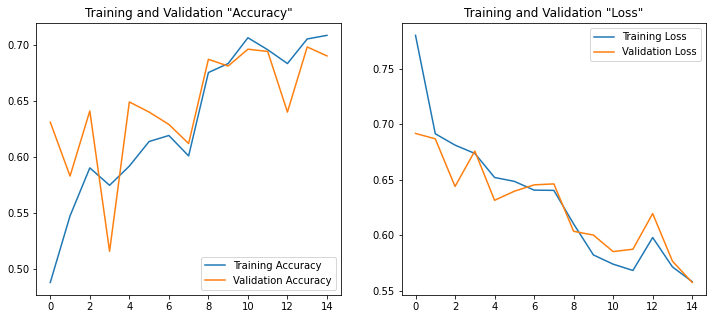

In [ ]:
# visualizing the Accuracy of the model developed
# accuracy:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# loss:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation "Accuracy"')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation "Loss"')
plt.show()



In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

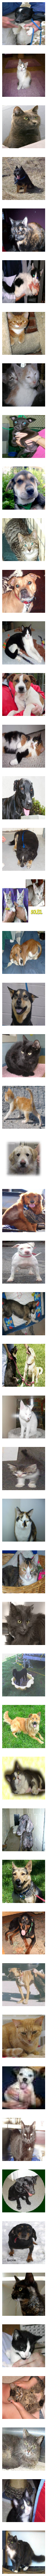

In [ ]:
test_images, _ = next(test_data_gen)
#probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
#plotImages(test_images, probabilities)
probabilities = model.predict(test_data_gen)
plotImages(test_images)



# Evaluation

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.68% of the images of cats and dogs.
You passed the challenge!
